In [1]:
from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch
import cv2
import sys

sys.path.append(r"/mnt/c/Users/gtraw/Projekt_badawczy")

### Prediction

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
sam2_model = build_sam2("configs/sam2.1/sam2.1_hiera_b+.yaml", "checkpoints/sam2.1_hiera_base_plus.pt", device=device, apply_postprocessing=False)

In [7]:
image_bgr = cv2.imread(r'/mnt/c/Users/gtraw/Projekt_badawczy/images/weti1_2024_11_05_10_35.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [8]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image_rgb)

In [9]:
def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

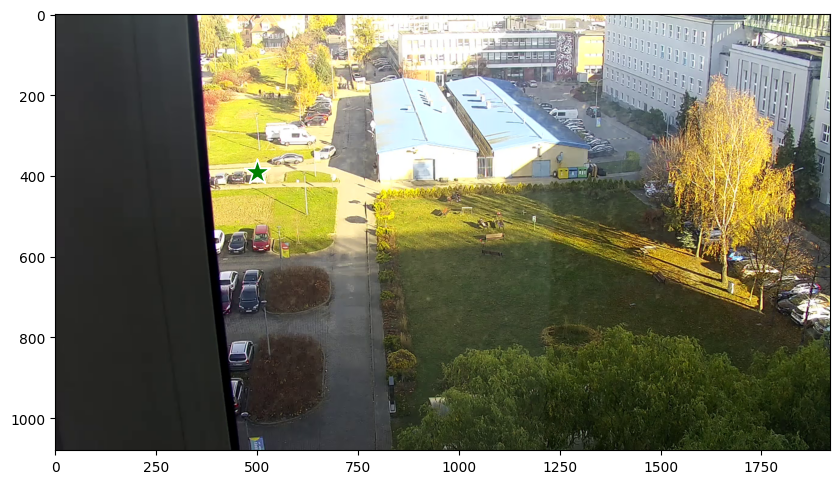

In [11]:
import numpy as np
import matplotlib.pyplot as plt

input_point = np.array([[500, 390]])
input_label = np.array([1])

plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show() 

In [12]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value 

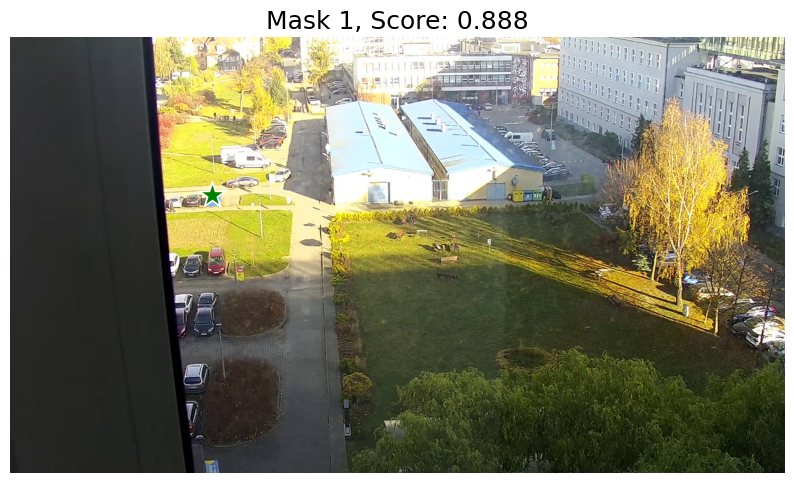

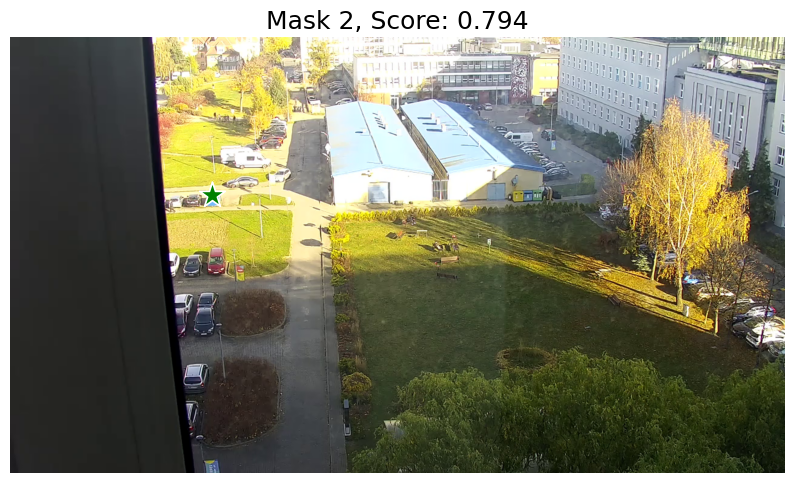

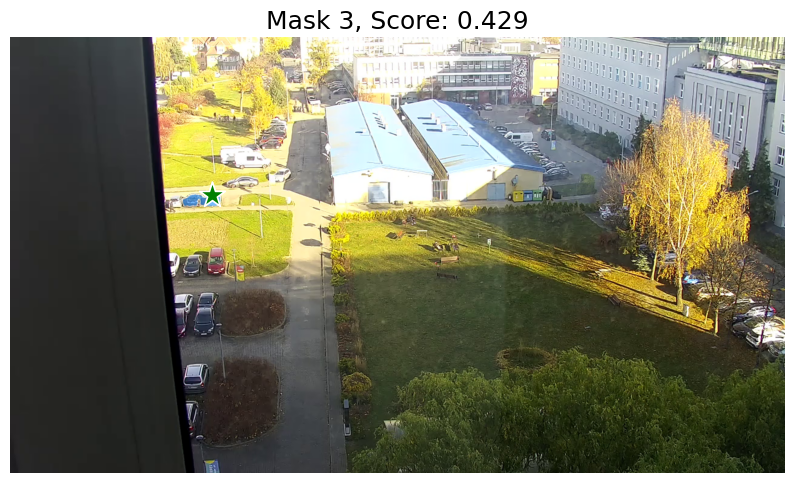

In [14]:
show_masks(image_rgb, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)

### Automatic

In [17]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [18]:
def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

In [21]:
image_bgr = cv2.imread(r'/mnt/c/Users/gtraw/Projekt_badawczy/images/weti1_2024_11_14_12_57.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

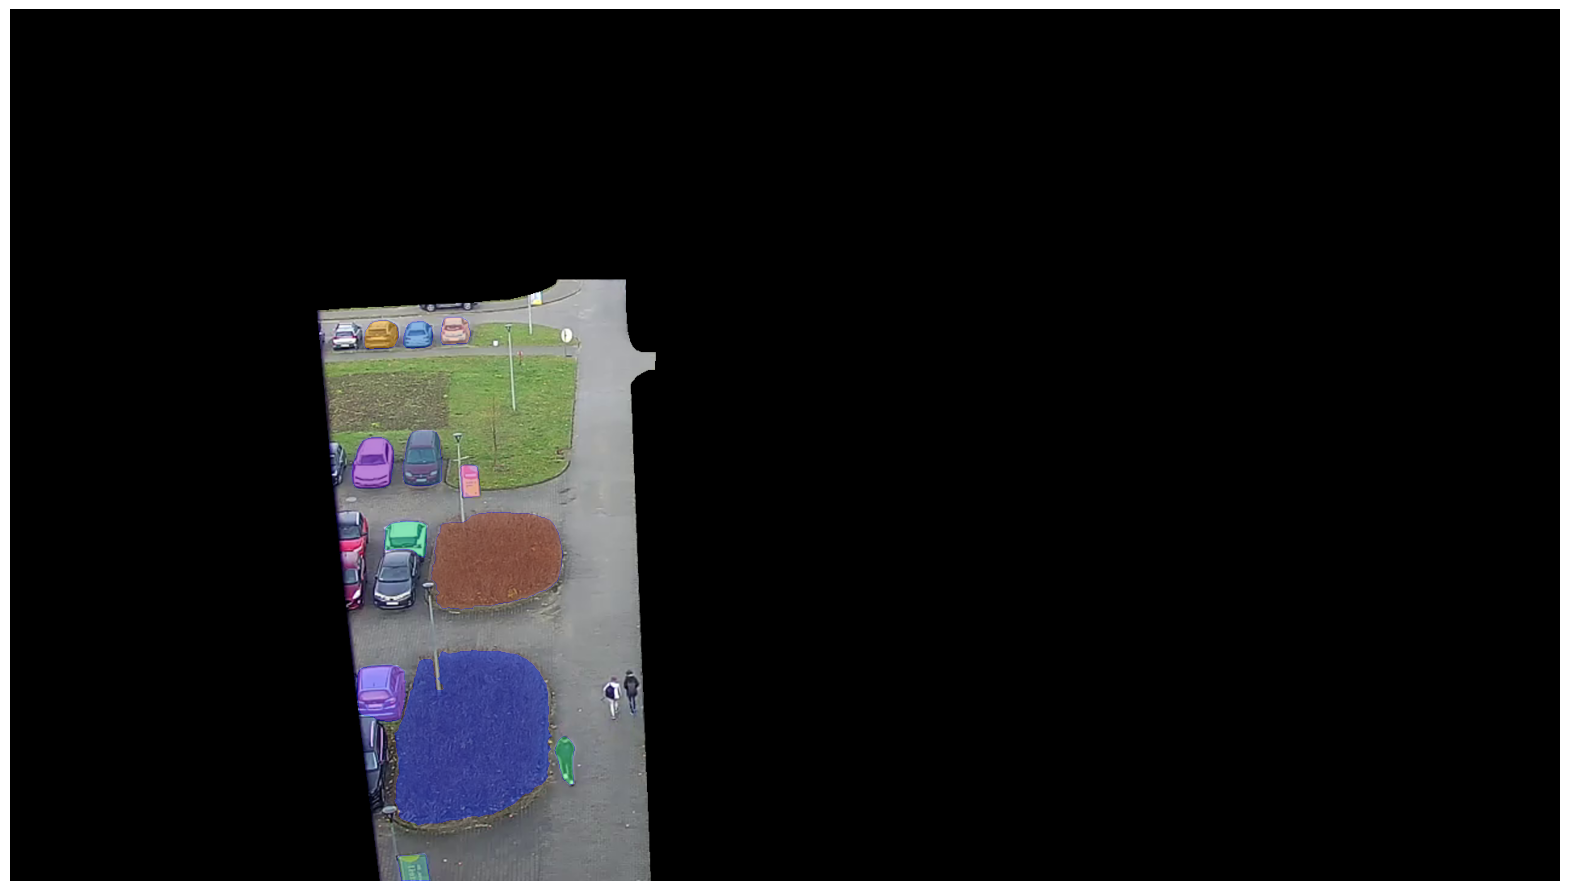

In [22]:
masks = mask_generator.generate(image_rgb)
plt.figure(figsize=(20, 20))
plt.imshow(image_rgb)
show_anns(masks)
plt.axis('off')
plt.show() 

In [1]:
print(masks[0].keys())
for mask in masks:
    print(mask['bbox'], mask['point_coords'], mask['crop_box'])

NameError: name 'masks' is not defined

### Segmentacja na całym zbiorze

In [6]:
# Settings

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
import torch
import cv2
import sys
import os
import time
import json

import numpy as np
from shapely.geometry import Polygon
from scipy.optimize import linear_sum_assignment

sys.path.append(r"/mnt/c/Users/gtraw/Projekt_badawczy")

# Images/results paths
input_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset'
output_dir = '/mnt/c/Users/gtraw/Projekt_badawczy/dataset_results'

# Model settings
model_info = {
    'tiny': ["configs/sam2.1/sam2.1_hiera_t.yaml", "checkpoints/sam2.1_hiera_tiny.pt"],
    'small': ["configs/sam2.1/sam2.1_hiera_s.yaml", "checkpoints/sam2.1_hiera_small.pt"],
    'base+': ["configs/sam2.1/sam2.1_hiera_b+.yaml", "checkpoints/sam2.1_hiera_base_plus.pt"],
    'large': ["configs/sam2.1/sam2.1_hiera_l.yaml", "checkpoints/sam2.1_hiera_large.pt"]
}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_name = 'base+'
config_yaml, model_checkpoint = model_info[model_name] 
sam2_model = build_sam2(config_yaml, model_checkpoint, device=device, apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

In [15]:
def transform_to_polygons(data, mode="points"):
    polygons = []
    if mode == "points":
        polygons = [points2polygon(d) for d in data]
    elif mode == "corners":
        polygons = [corners2polygon(d) for d in data]
    elif mode == "mask":
        polygons = [mask2polygon(d) for d in data]
    return [p for p in polygons if p is not None]
    
def corners2polygon(corners):
    x1, y1, x2, y2 = corners
    points = [(x1, y1), (x2, y1), (x2, y2), (x1, y2), (x1, y1)]
    
    return Polygon(points)
        
def points2polygon(points):
    return Polygon(points)

def mask2polygon(mask):
    mask = np.array(mask)
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    polygon = Polygon(shell=largest_contour.squeeze())
    
    if not polygon.is_valid:
        polygon = polygon.buffer(0)
    
    return polygon

def iou(polygon1, polygon2):
    union = polygon1.union(polygon2).area
    if union <= 0:
        return 0
    intersection = polygon1.intersection(polygon2).area
    return intersection / union

def build_similarity_matrix(objects_db, objects_pred):
    len_db, len_pred = len(objects_db), len(objects_pred)
    print(f"Matrix size: [{len_db}, {len_pred}]")
    similarity_matrix = np.zeros([len_db, len_pred])
    
    time_start = time.time()
    for x, obj_db in enumerate(objects_db):
        for y, obj_pred in enumerate(objects_pred):
            similarity_matrix[x, y] = iou(obj_db, obj_pred)
            print(f"Building similarity matrix: {x * len_pred + y + 1:>10}/{len_db*len_pred}", end='\r')
    time_end = time.time() - time_start
    print(f"Similarity matrix built in {time_end:.2f}s" + ' ' * 100)
    return similarity_matrix

def match_polygons(similarity_matrix):
    xs, ys = linear_sum_assignment(similarity_matrix, maximize=True)
    matching = [[x, y, similarity_matrix[x, y]] for x, y in zip(xs, ys) if similarity_matrix[x][y] > 0]
    return matching

def evaluate_segmentation(polygons_db, polygons_pred, matching, time, weather_info = [], model_info = []):
    results = {
        "weather": weather_info,
        "model": model_info,
        "time": time
    }
    num_db = len(polygons_db)
    num_pred = len(polygons_pred)
    num_matching = len(matching)

    results['ground_truth_objects'] = num_db
    results['segmented_objects'] = num_pred
    results['matched_objects'] = num_matching

    if num_pred != 0:
        results['precision'] = num_matching / num_pred
    else:
        results['precision'] = 0

    if num_db != 0:
        results['recall'] = num_matching / num_db
    else:
        results['recall'] = 0

    if results['precision'] + results['recall'] != 0:
        results['f1'] = 2 * results['precision'] * results['recall'] / (results['precision'] + results['recall'])
    else:
        results['precision'] = 0

    ious = []
    for x, y, _ in matching:
        ious.append(iou(polygons_db[x], polygons_pred[y]))

    if num_matching != 0:
        results['mean_iou'] = sum(ious) / num_matching
    else:
        results['mean_iou'] = 0

    return results

In [21]:
for model_name in ['large']: #model_info.keys():
    config_yaml, model_checkpoint = model_info[model_name] 
    sam2_model = build_sam2(config_yaml, model_checkpoint, device=device, apply_postprocessing=False)
    mask_generator = SAM2AutomaticMaskGenerator(sam2_model)
    output_dir_model = f"{output_dir}_{model_name}"
    print(f"output_dir: {output_dir_model}")

    # fix directories
    if not os.path.exists(output_dir_model):
        os.makedirs(output_dir_model)

    # for image in dir
    for image_file in os.listdir(input_dir):
        data_pred = {
            'model': model_name
        }
        
        # skip non-images
        if not image_file.endswith(('jpg', 'png')):
            continue
        print(f"\nImage: {image_file}")
        # load image
        image_bgr = cv2.imread(os.path.join(input_dir, image_file))
        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        # measure time
        time_start = time.time()
        # generate masks
        masks = mask_generator.generate(image_rgb)
        time_end = time.time() - time_start

        # save results
        data_pred['time'] = time_end
        data_pred['objects'] = []
        for mask in masks:
            object_dict = {
                'bbox': mask['bbox'],
                'point_coords': mask['point_coords'],
                'segmentation': mask['segmentation'].tolist()
            }
            data_pred['objects'].append(object_dict)

        # load labeled data
        data_filename = '.'.join(image_file.replace('_m', '').split('.')[:-1]) + '.json'
        with open(os.path.join(input_dir, data_filename), 'r') as f:
            data_db = json.load(f)

        data_db['polygons'] = transform_to_polygons([obj['points'] for obj in data_db['objects']])
        data_pred['polygons'] = transform_to_polygons([obj['segmentation'] for obj in data_pred['objects']], 'mask')

        sm = build_similarity_matrix(data_db['polygons'], data_pred['polygons'])
        matching = match_polygons(sm)

        result_dict = evaluate_segmentation(data_db['polygons'], data_pred['polygons'], matching, data_pred['time'], data_db['weather'], ['sam2.1', model_name])
        result_dict['filename'] = '.'.join(image_file.split('.')[:-1])

        json_path = os.path.join(output_dir_model, f"{'.'.join(image_file.split('.')[:-1])}.json")
        with open(json_path, 'w') as json_file:
            json.dump(result_dict, json_file, indent=4)

output_dir: /mnt/c/Users/gtraw/Projekt_badawczy/dataset_results_large

Image: weti1_2024_11_14_12_47.jpg
Matrix size: [14, 13]
Similarity matrix built in 0.01s                                                                                                    

Image: weti1_2024_11_14_12_47_m.jpg
Matrix size: [14, 41]
Similarity matrix built in 0.03s                                                                                                    

Image: weti1_2024_11_14_12_57.jpg
Matrix size: [14, 14]
Similarity matrix built in 0.01s                                                                                                    

Image: weti1_2024_11_14_12_57_m.jpg
Matrix size: [14, 41]
Similarity matrix built in 0.03s                                                                                                    

Image: weti1_2024_11_14_13_07.jpg
Matrix size: [14, 14]
Similarity matrix built in 0.02s                                                                             

#### Niżej zapisywanie wyników samej segmentacji do jsonów

In [4]:
# fix directories
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# for image in dir
for image_file in os.listdir(input_dir):
    result_dict = {
        'model': model_name
    }
    
    # skip non-images
    if not image_file.endswith(('jpg', 'png')):
        continue
    # load image
    image_bgr = cv2.imread(os.path.join(input_dir, image_file))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # measure time
    time_start = time.time()
    # generate masks
    masks = mask_generator.generate(image_rgb)
    time_end = time.time() - time_start

    # save results
    result_dict['time'] = time_end
    result_dict['objects'] = []
    for mask in masks:
        object_dict = {
            'bbox': mask['bbox'],
            'point_coords': mask['point_coords'],
            'segmentation': mask['segmentation'].tolist()
        }
        result_dict['objects'].append(object_dict)
    json_path = os.path.join(output_dir, f"{'.'.join(image_file.split('.')[:-1])}.json")
    with open(json_path, 'w') as json_file:
        json.dump(result_dict, json_file, indent=4)

/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:775.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value 

### Niżej jakieś dziadostwo, bo nie działało xd

In [6]:
import hydra
from sam2.build_sam import build_sam2

# hydra is initialized on import of sam2, which sets the search path which can't be modified
# so we need to clear the hydra instance
hydra.core.global_hydra.GlobalHydra.instance().clear()
# reinit hydra with a new search path for configs
hydra.initialize_config_module('sam2/sam2/configs/sam2.1', version_base='1.2')

# this should work now
model = build_sam2("sam2.1_hiera_b+.yaml", "checkpoints/sam2.1_hiera_base_plus.pt")

MissingConfigException: Primary config module 'sam2.sam2.configs.sam2.1' not found.
Check that it's correct and contains an __init__.py file

In [5]:
sam2_checkpoint = "checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "sam2.1_hiera_b+.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

MissingConfigException: Cannot find primary config 'sam2.1_hiera_b+.yaml'. Check that it's in your config search path.

Config search path:
	provider=hydra, path=pkg://hydra.conf
	provider=main, path=pkg://sam2
	provider=schema, path=structured://

In [2]:
image_bgr = cv2.imread(r'/mnt/c/Users/gtraw/Projekt_badawczy/images/weti1_2024_11_05_10_35.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [10]:
import hydra
from sam2.build_sam import build_sam2

# hydra is initialized on import of sam2, which sets the search path which can't be modified
# so we need to clear the hydra instance
hydra.core.global_hydra.GlobalHydra.instance().clear()
# reinit hydra with a new search path for configs
hydra.initialize_config_module('/mnt/c/Users/gtraw/Projekt_badawczy/sam2/sam2/configs/sam2.1', version_base='1.2')

hydra.initialize_config_module()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam2_checkpoint = r"/mnt/c/Users/gtraw/Projekt_badawczy/checkpoints/SAM21/sam2.1_hiera_base_plus.pt"
model_cfg = r"sam2.1_hiera_b+.yaml"
sam2 = build_sam2(model_cfg, sam2_checkpoint, device ='cuda:2', apply_postprocessing=False)
mask_generator = SAM2AutomaticMaskGenerator(sam2)

MissingConfigException: Primary config module 'sam2.configs.sam2.1' not found.
Check that it's correct and contains an __init__.py file

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 